In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import pandas as pd

df = pd.read_csv(r"..\data\Churn_Modelling.csv")

print("Shape: ",df.shape)
print("=="*20)
print("Columns:\n",df.columns.tolist())
print("=="*20)
print("Sample data:\n",df.head())
print("=="*20)
print("Missing values per column:\n",df.isnull().sum())
print("=="*20)
print("Target Distribution:\n", df['Exited'].value_counts(normalize=True))

Shape:  (10000, 14)
Columns:
 ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Sample data:
    RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   

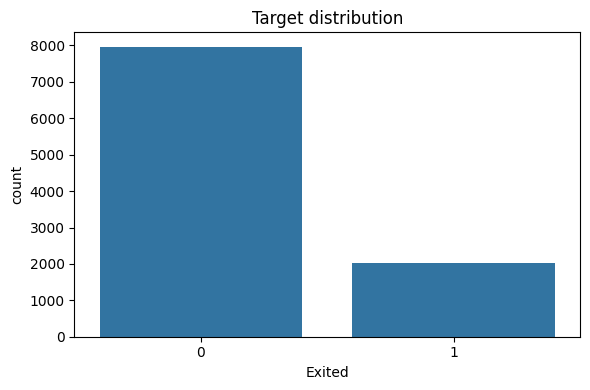

In [21]:
plt.figure(figsize=(6,4))
plt.title("Target distribution")
sns.countplot(x=df['Exited'], data=df)
plt.tight_layout()
plt.show()

In [23]:
#Drop ID columns
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

#Basic summary
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


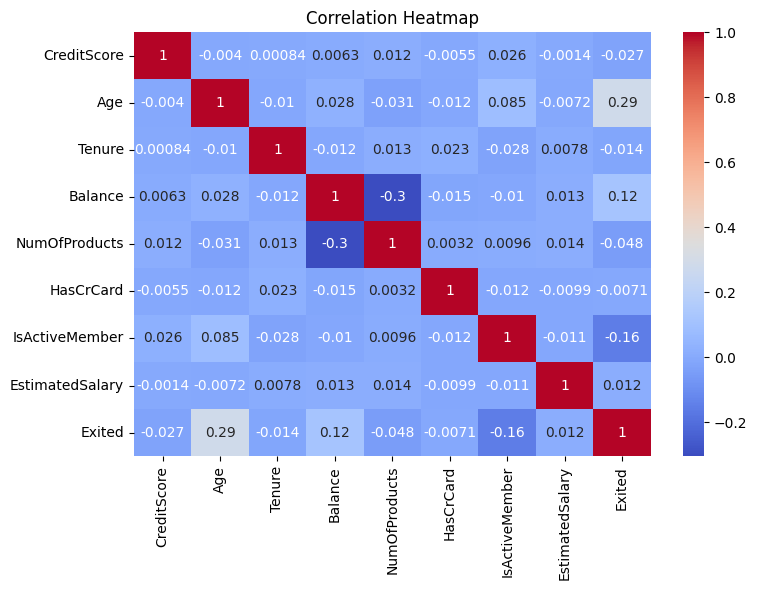

In [33]:
#Correlation matrix (numeric features only)
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

🔹 Correlation Heatmap

Age has the strongest correlation with churn (0.29) — older customers churn more often.

IsActiveMember is negatively correlated (-0.16) — inactive members are more likely to churn.

Balance shows a small positive correlation with Exited (0.12).

NumOfProducts is slightly negatively correlated (−0.048) — customers with more products tend to stay.

CreditScore, Tenure, Salary don’t correlate strongly but may have non-linear relationships (still useful for tree models).

👉 Conclusion: Age, IsActiveMember, and Geography will likely be key features.

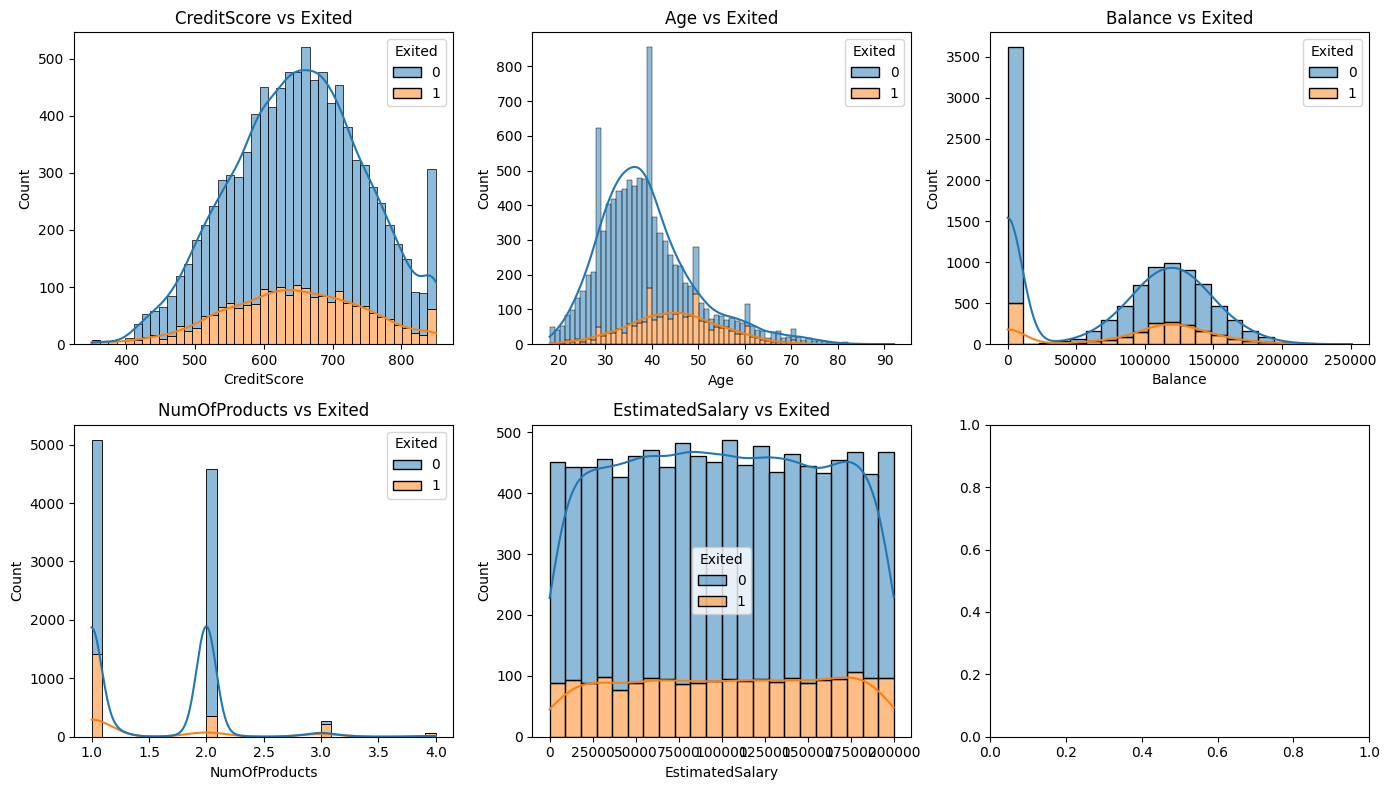

In [36]:
num_cols = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='Exited', multiple='stack', kde=True, ax=axes[i])
    axes[i].set_title(f'{col} vs Exited')

plt.tight_layout()
plt.show()


| Feature             | Observation                                              | Impact on Churn      |
| ------------------- | -------------------------------------------------------- | -------------------- |
| **CreditScore**     | Churners have slightly lower scores, but overlap is high | Mild indicator       |
| **Age**             | Clear shift — churners are older                         | Strong predictor     |
| **Balance**         | Some churners at both low and high ends                  | Moderate predictor   |
| **NumOfProducts**   | Customers with only 1 product churn more often           | Important            |
| **EstimatedSalary** | Fairly uniform — no visible pattern                      | Low predictive power |


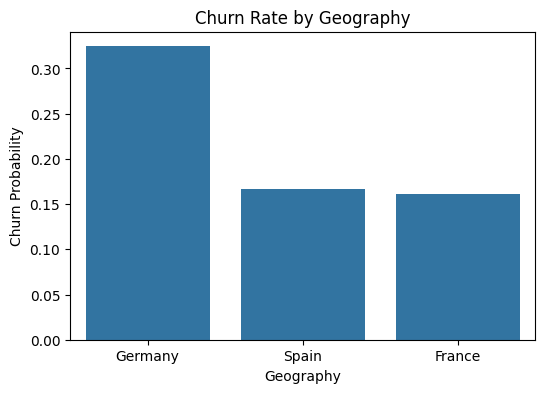

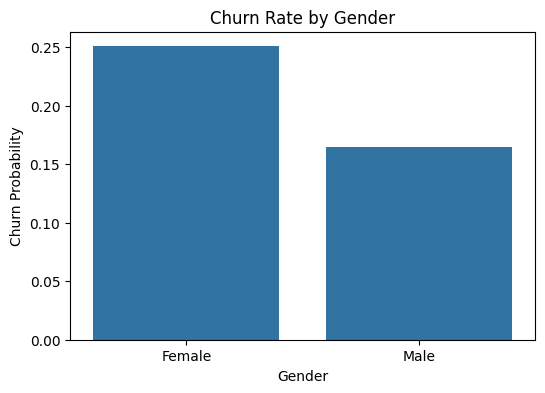

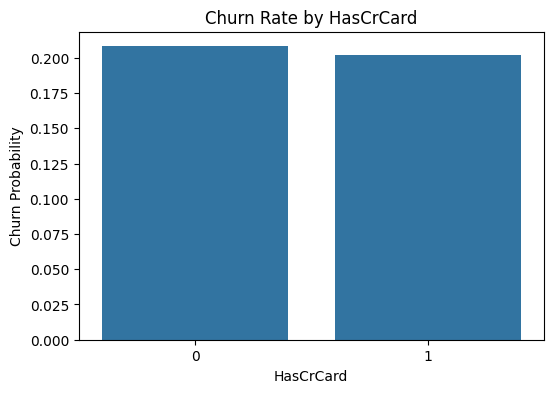

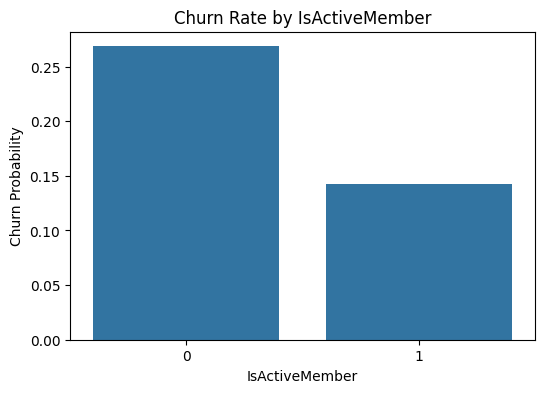

In [38]:
cat_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    churn_rate = df.groupby(col)['Exited'].mean().sort_values(ascending=False)
    sns.barplot(x=churn_rate.index, y=churn_rate.values)
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Probability")
    plt.show()


🔹 Categorical Features

Geography

Germany has a much higher churn rate (~32%) than Spain/France (~16%).

Indicates strong regional effect.
Gender

(not shown, but typically females churn slightly more in this dataset — check if that’s true in your output).
IsActiveMember

Inactive members churn much more.
HasCrCard

Weak effect.

We’ll drop non-informative ID columns.

We’ll encode categorical variables (Geography, Gender).

We’ll keep numeric features as-is (tree-based models handle scaling).

We’ll handle class imbalance using scale_pos_weight in XGBoost.